In [1]:
# Import the required modules
import numpy as np                # scientific library
import pandas as pd

import matplotlib.pyplot as plt   # for creating plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # improve resolution


from scipy.integrate import odeint # numerical solver of odes

from math import erf # error function

import itertools

In [2]:
# Use the best fitted parameters as the base case
Rc=4
sigma=1/7
beta=Rc*sigma
omega=1/180
omega1=1/360 #omega_dash
gamma=1/90

var=[0,0.55,0.75,0.85] #epsilon
var1=[0.05,0.25,0.3,0.4] #epsilon_dash
delta_m=[1,1,1,1]#1-delta

phi0=2*10**(-3) #1-phi_0
phi1=phi0*(1-0.48)/(1-0.15)#1-phi_1
phi2=phi0*(1-0.9)/(1-0.6)#1-phi_2
phi3=phi0*(1-0.95)/(1-0.7)#1-phi_3
phi_m=[phi0,phi1,phi2,phi3]#1-phi

theta=[56/67,42/67,6/67]
theta_0=[1,0.95,0.9]
N=67*10**6

y0=np.zeros(20)
y0[0]=N-1
y0[4]=1
T=365*5
t=np.arange(0,T,1)

In [3]:
# Define the ODE. 
def model(y, t, beta, sigma, omega, omega1, gamma, var, var1, delta_m, phi_m, theta, N,scale):
    
    V0,V1,V2,V3,I0,I1,I2,I3,R0,R1,R2,R3,T0,T1,T2,T3,M0,M1,M2,M3 = y # specify variables
    
    I_m=[I0,I1,I2,I3]
    pi=sigma*np.dot(phi_m,I_m)
    I=np.dot(I_m,delta_m)
    
    H0=0.5+0.5*erf((((V0+I0+R0+T0)/N)-(1-theta[0]))/scale)
    H1=0.5+0.5*erf((((V0+I0+R0+T0+V1+I1+R1+T1)/N)-(1-theta[1]))/scale)
    H2=0.5+0.5*erf((((V0+I0+R0+T0+V1+I1+R1+T1+V2+I2+R2+T2)/N)-(1-theta[2]))/scale)

    dydt= np.empty(len(y)) # create empty vector and then fill entries with the corresponding RHS
    dydt[0]=pi-(beta*V0/N)*(1-var[0])*I-gamma*V0*H0 #dV0dt
    dydt[4]=(beta*V0/N)*(1-var[0])*I+(beta*T0/N)*(1-var1[0])*I-sigma*I0 #dI0dt
    dydt[8]=sigma*(1-phi_m[0])*I0-omega*R0#dR0dt
    dydt[16]=sigma*phi_m[0]*I0 #dM0dt
    dydt[12]=omega*R0-(beta/N)*T0*(1-var1[0])*I-gamma*T0*H0 #dT0dt
    
    dydt[1]=gamma*(V0+T0)*H0-(beta*V1/N)*(1-var[1])*I-omega1*V1-gamma*V1*H1 #dV1dt
    dydt[5]=(beta/N)*(V1*(1-var[1])+T1*(1-var1[1]))*I-sigma*I1 #dI1dt
    dydt[9]=sigma*(1-phi_m[1])*I1-omega*R1 #dR1dt
    dydt[17]=sigma*phi_m[1]*I1 #dM1dt
    dydt[13]=omega*R1-(beta/N)*T1*(1-var1[1])*I-gamma*T1*H1+omega1*V1 #dT1dt
    
    dydt[2]=gamma*(T1+V1)*H1-(beta*V2/N)*(1-var[2])*I-omega1*V2-gamma*V2*H2 #dV2dt
    dydt[6]=(beta/N)*(V2*(1-var[2])+T2*(1-var1[2]))*I-sigma*I2 #dI2dt
    dydt[10]=sigma*(1-phi_m[2])*I2-omega*R2 #dR2dt
    dydt[18]=sigma*phi_m[2]*I2 #dM2dt
    dydt[14]=omega*R2-(beta/N)*T2*(1-var1[2])*I-gamma*T2*H2+omega1*V2 #dT2dt
    
    dydt[3]=gamma*(T2+V2)*H2-(beta*V3/N)*(1-var[3])*I-omega1*V3+gamma*T3 #dV3dt
    dydt[7]=(beta/N)*(V3*(1-var[3])+T3*(1-var1[3]))*I-sigma*I3 #dI3dt
    dydt[11]=sigma*(1-phi_m[3])*I3-omega*R3#dR3dt
    dydt[19]=sigma*phi_m[3]*I3 #dM3dt
    dydt[15]=omega*R3+omega1*V3-(beta/N)*T3*(1-var1[3])*I-gamma*T3 #dT3dt
    
    
    
    return dydt # the function will return the value of the ODE RHS

In [4]:
def get_compartment(sol):
    def get_sum(x):
        return x[:,0]+x[:,1]+x[:,2]+x[:,3]
    V=sol[:,0:4]
    I=sol[:,4:8]
    R=sol[:,8:12]
    T=sol[:,12:16]
    M=sol[:,16:]
    stage0=V[:,0]+I[:,0]+R[:,0]+T[:,0]+M[:,0]
    stage1=V[:,1]+I[:,1]+R[:,1]+T[:,1]+M[:,1]
    stage2=V[:,2]+I[:,2]+R[:,2]+T[:,2]+M[:,2]
    stage3=V[:,3]+I[:,3]+R[:,3]+T[:,3]+M[:,3]
    Vt=get_sum(V)
    It=get_sum(I)
    Rt=get_sum(R)
    Tt=get_sum(T)
    Mt=get_sum(M)
    return V,I,R,T,M,Vt,It,Rt,Tt,Mt,stage0,stage1,stage2,stage3

In [5]:
#compare I0,I1,I2,I3 with numerical results
def check_I(I,It,sigma,theta,omega,omega1,var,var1,gamma,Rc,N):
    Isum=It[-1]/N
    theta0=1
    theta1,theta2,theta3=theta
    theta4=0
    
    # Solve Equation 15 to get theoratical equilibrium infections
    if Isum<=0.0005:
        try_I=np.arange(0.0005,0.02,0.0001)
    else:
        try_I=np.arange(Isum*0.5,Isum*2,0.0001)
    AI=(theta0-theta1)/((try_I*(1+(sigma/omega)))+(1/(Rc*(1-var1[0]))))
    BI=(theta1-theta2)/((try_I*(1+(sigma/omega)))+(1/(Rc*(1-var1[1]))))
    CI=(theta2-theta3)/((try_I*(1+(sigma/omega)))+(1/(Rc*(1-var1[2]))))
    
    KI=((1-var[3])*sigma*Rc*try_I+omega1)/gamma
    d1=try_I*(1+(sigma/(omega)))
    d2=(1+KI)
    d3=Rc*(1-var[3]+(1-var1[3])*KI)
    DI=(theta3-theta4)/(d1+(d2/d3))
    result=np.abs(np.ones(len(try_I))-(AI+BI+CI+DI))
    result2=np.abs(np.zeros(len(try_I))-result)
    
    print("Experimental result: "+str(Isum)) #print the experimental result
    
    I_pre_year=Isum*sigma*365
    print("Per year: "+str(I_pre_year))
    return try_I[np.argmin(result2)] #return the theoratical result

In [6]:
def get_Re(Rc,I,V,T,delta_m,var,var1):
    # Use equation (5) to get Re(t)
    result=np.zeros(len(I))
    for i in range(len(I)):
        sI=np.dot(delta_m,I[i])
        sV=np.dot((np.ones(4)-var),V[i])
        sT=np.dot((np.ones(4)-var1),T[i])
        if np.sum(I[i])!=0:
            result[i]=(Rc*sI*(sV+sT))/(N*np.sum(I[i]))
    return result
    
    

In [7]:
def get_dm(Mt):
    # Return daily death rate
    result=[0]
    for i in range(1,len(Mt)):
        result.append(Mt[i]-Mt[i-1])
    result=np.array(result)
    return result

In [8]:
sol=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma, var, var1, delta_m, phi_m, theta, N,0.001))
#sol=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma, var, var1, delta_m, [0,0,0,0], theta, N,0.001))
V,I,R,T,M,Vt,It,Rt,Tt,Mt,stage0,stage1,stage2,stage3=get_compartment(sol)
print(get_dm(Mt)[-1])

208.4020324657322


In [9]:
print((V[-1,:]+I[-1,:]+R[-1,:]+T[-1,:])/N)
print(sol[-1,:]/N)

[0.16227578 0.20871819 0.53674075 0.09226528]
[2.28779860e-04 2.12277462e-04 2.08350720e-04 3.73441261e-02
 4.29838288e-03 5.12190783e-03 1.28517810e-02 1.45165255e-03
 1.10309207e-01 1.31545373e-01 3.30281460e-01 3.73096385e-02
 4.74394133e-02 7.18386294e-02 1.93399156e-01 1.61598647e-02
 3.22163519e-03 1.74788901e-03 1.43536911e-03 1.14437457e-04]


In [10]:
print(Vt[-1]/N)
print(It[-1]/N)
print(Rt[-1]/N)
print(Tt[-1]/N)

0.037993534122801195
0.02372372429808102
0.6094456781860297
0.3288370633930889


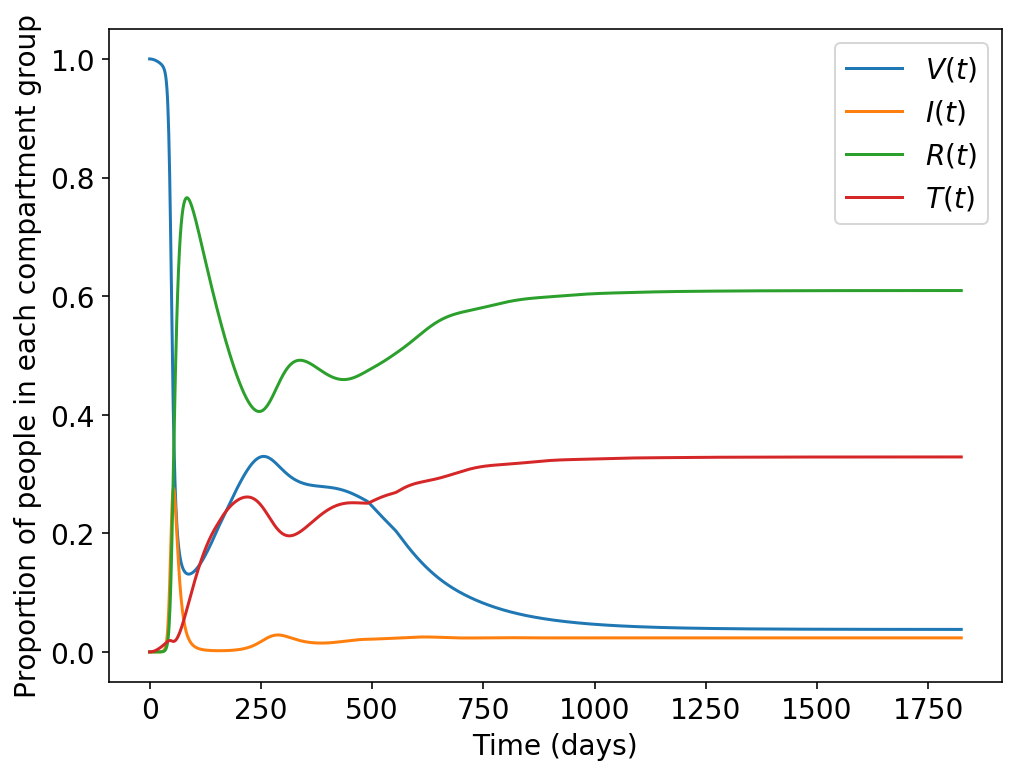

In [11]:
plt.rc('font', size=14) 
fig = plt.figure(figsize=(8,6))
plt.plot(t,Vt/N,label=r"$V(t)$")
plt.plot(t,It/N,label=r"$I(t)$")
plt.plot(t,Rt/N,label=r"$R(t)$")
plt.plot(t,Tt/N,label=r"$T(t)$")
#plt.plot(t,Mt/N,label=r"M(t)")
#plt.vlines(70, 0, 1, color='c',linestyle ="--",alpha=0.8)
#plt.vlines(170, 0, 1, color='c',linestyle ="--",alpha=0.8)
#plt.vlines(700, 0, 1, color='c',linestyle ="--",alpha=0.8)
#plt.axhline(y = 0.064, color ="purple", linestyle ="--")
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Proportion of people in each compartment group")
plt.show()

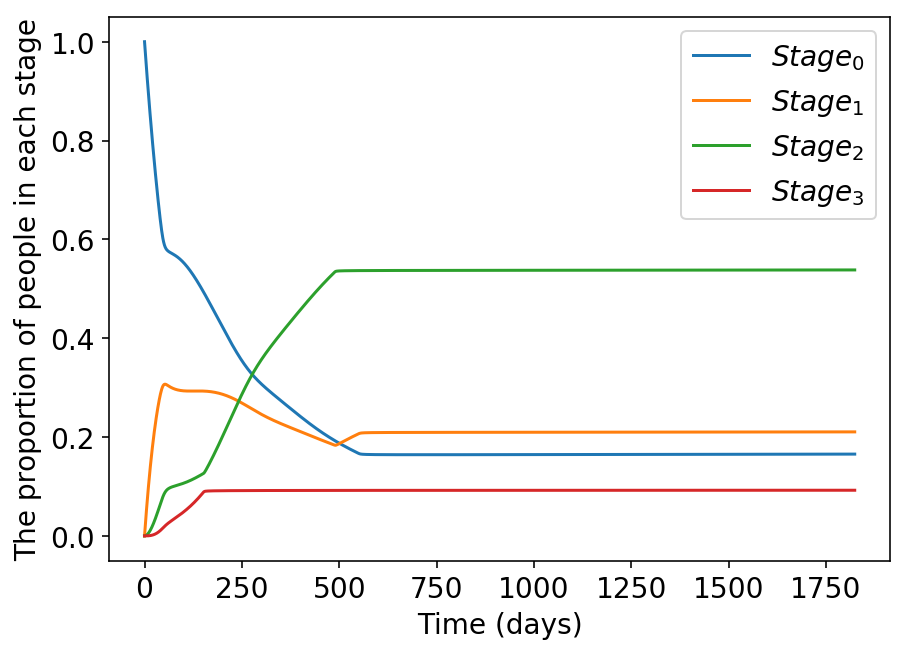

In [12]:
fig = plt.figure(figsize=(7,5))
plt.plot(t,stage0/N,label=r"$Stage_0$")
plt.plot(t,stage1/N,label=r"$Stage_1$")
plt.plot(t,stage2/N,label=r"$Stage_2$")
plt.plot(t,stage3/N,label=r"$Stage_3$")
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("The proportion of people in each stage")
plt.show()

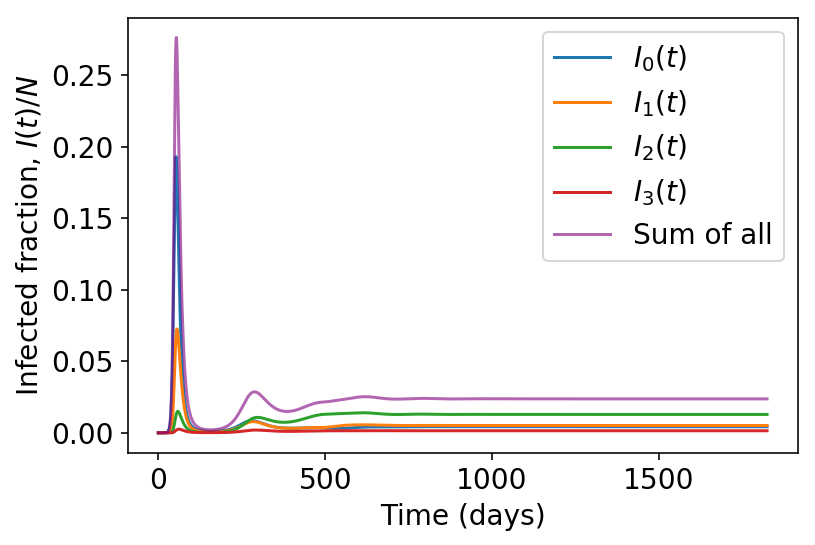

In [13]:
plt.plot(t,I[:,0]/N,label=r"$I_{0}(t)$")
plt.plot(t,I[:,1]/N,label=r"$I_{1}(t)$")
plt.plot(t,I[:,2]/N,label=r"$I_{2}(t)$")
plt.plot(t,I[:,3]/N,label=r"$I_{3}(t)$")
plt.plot(t,It/N, alpha=0.6,color="purple",label="Sum of all")
plt.legend(loc="upper right")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

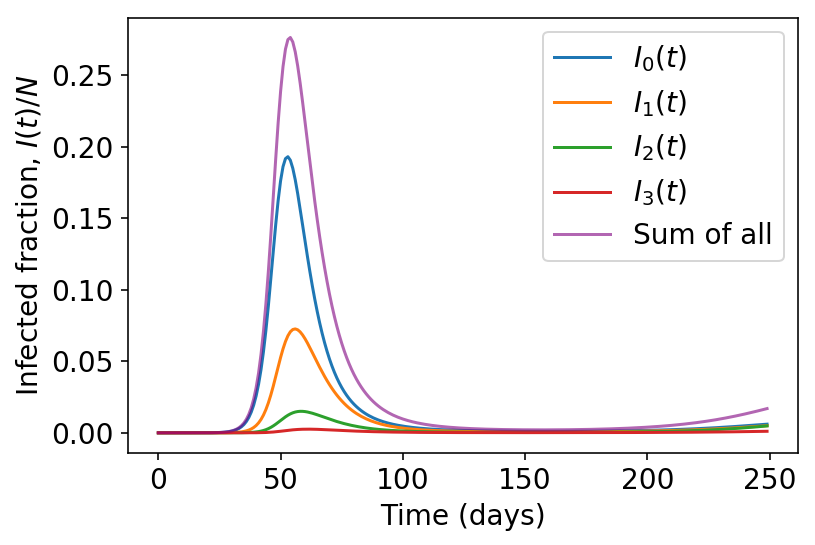

In [14]:
plt.plot(t[:250],I[:250,0]/N,label=r"$I_{0}(t)$")
plt.plot(t[:250],I[:250,1]/N,label=r"$I_{1}(t)$")
plt.plot(t[:250],I[:250,2]/N,label=r"$I_{2}(t)$")
plt.plot(t[:250],I[:250,3]/N,label=r"$I_{3}(t)$")
plt.plot(t[:250],It[:250]/N, alpha=0.6,color="purple",label="Sum of all")
plt.legend(loc="upper right")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

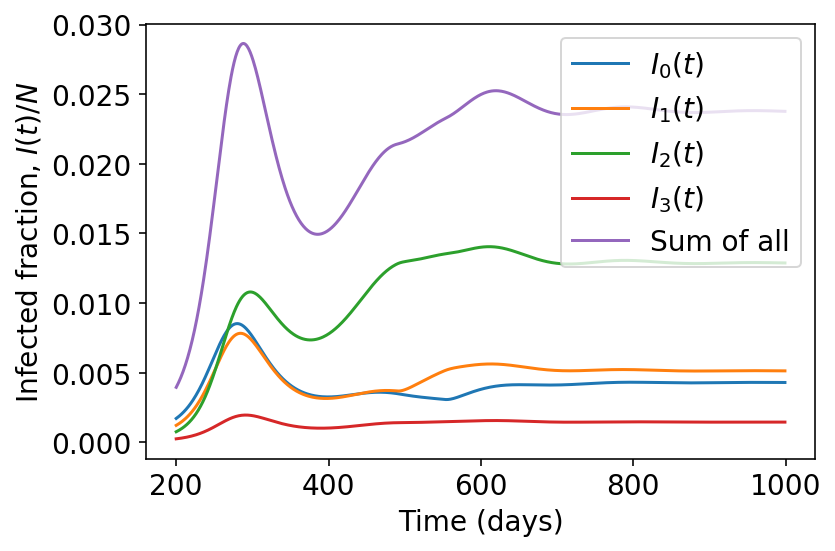

In [15]:
plt.plot(t[200:1000],I[200:1000,0]/N,label=r"$I_{0}(t)$")
plt.plot(t[200:1000],I[200:1000,1]/N,label=r"$I_{1}(t)$")
plt.plot(t[200:1000],I[200:1000,2]/N,label=r"$I_{2}(t)$")
plt.plot(t[200:1000],I[200:1000,3]/N,label=r"$I_{3}(t)$")
plt.plot(t[200:1000],It[200:1000]/N,label="Sum of all")
plt.legend(loc='upper right')
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

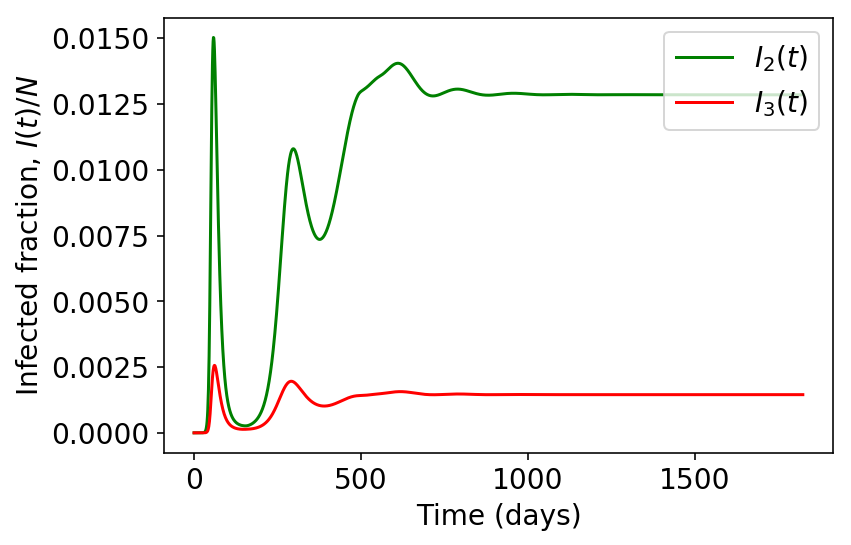

In [16]:
plt.plot(t,I[:,2]/N,color="green",label=r"$I_{2}(t)$")
plt.plot(t,I[:,3]/N,color="red",label=r"$I_{3}(t)$")
plt.legend(loc="upper right")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

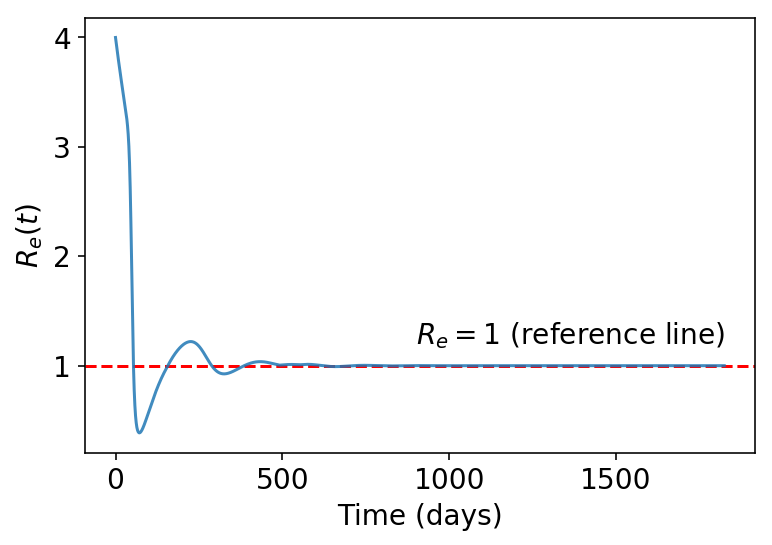

In [17]:
plt.axhline(y = 1.0, color ="red", linestyle ="--")
plt.plot(t,get_Re(Rc,I,V,T,delta_m,var,var1),alpha=0.85)
plt.text(900,1.2,r"$R_{e}=1$ (reference line)")
#plt.vlines(150, 0, 4, color='c',linestyle ="--",alpha=0.8)
plt.xlabel("Time (days)")
plt.ylabel(r"$R_{e}(t)$")
plt.show()

In [18]:
# Use equation (7) to get the cumulative infections within five years

def get_I_cum(sigma,t,Re,It):
    def f(t,Re,It):
        return Re[t]*It[t]
    def simpson(a,b,Re,It):
        #Use Simpson's rule to get the integration result
        m=int((a+b)/2)
        return ((b-a)*(f(a,Re,It)+f(b,Re,It)+4*f(m,Re,It)))/ 6
    
    result=0
    for i in range(len(t)-1):
        result+=sigma*simpson(i,t[i+1],Re,It)
    return result+It[-1]

In [19]:
#check I0,I1,I2,I3
print(check_I(I,It,sigma,theta,omega,omega1,var,var1,gamma,Rc,N))

Experimental result: 0.02372372429808102
Per year: 1.2370227669713674
0.023761862149040438


In [20]:
Re=get_Re(Rc,I,V,T,delta_m,var,var1)
print(get_I_cum(sigma,t,Re,It)/(N))

6.299749052195159


In [21]:
# Get the result with a big theta value (theta_0)
sol_0=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))
V_0,I_0,R_0,T_0,M_0,Vt_0,It_0,Rt_0,Tt_0,Mt_0,stage0_0,stage1_0,stage2_0,stage3_0=get_compartment(sol_0)
print(check_I(I_0,It_0,sigma,theta_0,omega,omega1,var,var1,gamma,Rc,N))
Re_0=get_Re(Rc,I_0,V_0,T_0,delta_m,var,var1)
print(get_I_cum(sigma,t,Re_0,It_0)/(N))
print(get_I_cum(sigma,t,Re_0,It_0)/(5*N))

Experimental result: 0.0049408973780934095
Per year: 0.2576325061434421
0.0051704486890467
2.151893350618132
0.4303786701236264


# Change omega

In [22]:
sol_5=odeint(model, y0, t, args=(beta, sigma, 1/45, 1/180, gamma, var, var1, delta_m, phi_m, theta, N,0.001))
sol_2=odeint(model, y0, t, args=(beta, sigma, 1/90, 1/360, gamma, var, var1, delta_m, phi_m, theta, N,0.001))
sol_3=odeint(model, y0, t, args=(beta, sigma, 1/90, 1/180, gamma, var, var1, delta_m, phi_m, theta, N,0.001))
sol_4=odeint(model, y0, t, args=(beta, sigma, 1/45, 1/360, gamma, var, var1, delta_m, phi_m, theta, N,0.001))
sol_1=odeint(model, y0, t, args=(beta, sigma, 1/180, 1/180, gamma, var, var1, delta_m, phi_m, theta, N,0.001))
sol_0=odeint(model, y0, t, args=(beta, sigma, 1/180, 1/360, gamma, var, var1, delta_m, phi_m, theta, N,0.001))

V_0,I_0,R_0,T_0,M_0,Vt_0,It_0,Rt_0,Tt_0,Mt_0,stage0_0,stage1_0,stage2_0,stage3_0=get_compartment(sol_0)
V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)
V_2,I_2,R_2,T_2,M_2,Vt_2,It_2,Rt_2,Tt_2,Mt_2,stage0_2,stage1_2,stage2_2,stage3_2=get_compartment(sol_2)
V_3,I_3,R_3,T_3,M_3,Vt_3,It_3,Rt_3,Tt_3,Mt_3,stage0_3,stage1_3,stage2_3,stage3_3=get_compartment(sol_3)
V_4,I_4,R_4,T_4,M_4,Vt_4,It_4,Rt_4,Tt_4,Mt_4,stage0_4,stage1_4,stage2_4,stage3_4=get_compartment(sol_4)
V_5,I_5,R_5,T_5,M_5,Vt_5,It_5,Rt_5,Tt_5,Mt_5,stage0_5,stage1_5,stage2_5,stage3_5=get_compartment(sol_5)

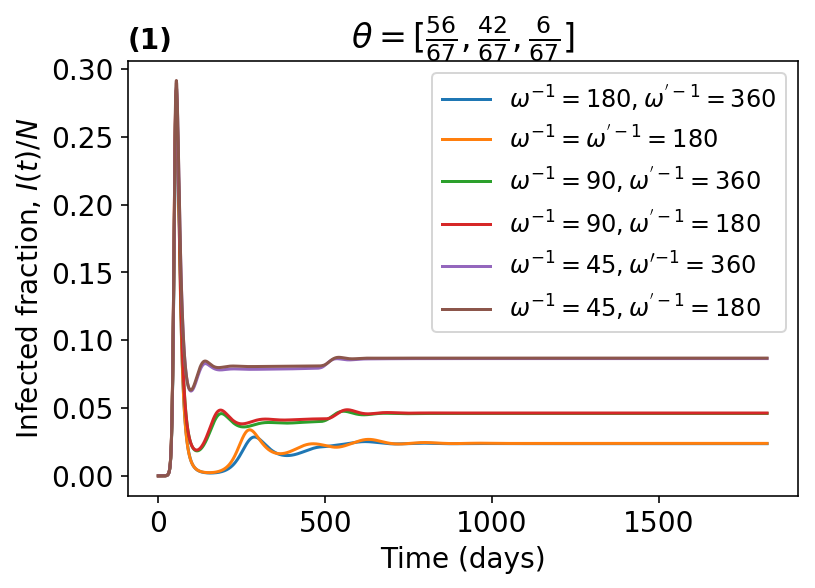

In [23]:
plt.plot(t,It_0/N,label=r"$\omega^{-1}=180,\omega^{'-1}=360$")
plt.plot(t,It_1/N,label=r"$\omega^{-1}=\omega^{'-1}=180$")
plt.plot(t,It_2/N,label=r"$\omega^{-1}=90,\omega^{'-1}=360$")
plt.plot(t,It_3/N,label=r"$\omega^{-1}=90,\omega^{'-1}=180$")
plt.plot(t,It_4/N,label=r"$\omega^{-1}=45,\omega'^{-1}=360$")
plt.plot(t,It_5/N,label=r"$\omega^{-1}=45,\omega^{'-1}=180$")
plt.legend(fontsize=12)
plt.title('(1)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[\frac{56}{67},\frac{42}{67},\frac{6}{67}]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [24]:
print(check_I(I_0,It_0,sigma,theta,1/180,1/360,var,var1,gamma,Rc,N))
print()
print(check_I(I_1,It_1,sigma,theta,1/180,1/180,var,var1,gamma,Rc,N))
print()
print(check_I(I_2,It_2,sigma,theta,1/90,1/360,var,var1,gamma,Rc,N))
print()
print(check_I(I_3,It_3,sigma,theta,1/90,1/180,var,var1,gamma,Rc,N))
print()
print(check_I(I_4,It_4,sigma,theta,1/45,1/360,var,var1,gamma,Rc,N))
print()
print(check_I(I_5,It_5,sigma,theta,1/45,1/180,var,var1,gamma,Rc,N))
print()
Re_0=get_Re(Rc,I_0,V_0,T_0,delta_m,var,var1)
Re_1=get_Re(Rc,I_1,V_1,T_1,delta_m,var,var1)
Re_2=get_Re(Rc,I_2,V_2,T_2,delta_m,var,var1)
Re_3=get_Re(Rc,I_3,V_3,T_3,delta_m,var,var1)
Re_4=get_Re(Rc,I_4,V_4,T_4,delta_m,var,var1)
Re_5=get_Re(Rc,I_5,V_5,T_5,delta_m,var,var1)
print(get_I_cum(sigma,t,Re_0,It_0)/(N))
print(get_I_cum(sigma,t,Re_1,It_1)/(N))
print(get_I_cum(sigma,t,Re_2,It_2)/(N))
print(get_I_cum(sigma,t,Re_3,It_3)/(N))
print(get_I_cum(sigma,t,Re_4,It_4)/(N))
print(get_I_cum(sigma,t,Re_5,It_5)/(N))

Experimental result: 0.02372372429808102
Per year: 1.2370227669713674
0.023761862149040438

Experimental result: 0.02392667702265254
Per year: 1.2476053018954538
0.023963338511326197

Experimental result: 0.04601622579138187
Per year: 2.399417487693483
0.04610811289569079

Experimental result: 0.04630859691983572
Per year: 2.414662553677148
0.04635429845991772

Experimental result: 0.08647256287616567
Per year: 4.508926492828638
0.08653628143808408

Experimental result: 0.08682305750509028
Per year: 4.527202284193993
0.08691152875254639

6.299749052195159
6.483213348684039
11.899482912490607
12.101407718891265
22.17016574264617
22.36252733748395


In [25]:
sol_5=odeint(model, y0, t, args=(beta, sigma, 1/45, 1/180, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))
sol_2=odeint(model, y0, t, args=(beta, sigma, 1/90, 1/360, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))
sol_3=odeint(model, y0, t, args=(beta, sigma, 1/90, 1/180, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))
sol_4=odeint(model, y0, t, args=(beta, sigma, 1/45, 1/360, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))
sol_1=odeint(model, y0, t, args=(beta, sigma, 1/180, 1/180, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))
sol_0=odeint(model, y0, t, args=(beta, sigma, 1/180, 1/360, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))

V_0,I_0,R_0,T_0,M_0,Vt_0,It_0,Rt_0,Tt_0,Mt_0,stage0_0,stage1_0,stage2_0,stage3_0=get_compartment(sol_0)
V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)
V_2,I_2,R_2,T_2,M_2,Vt_2,It_2,Rt_2,Tt_2,Mt_2,stage0_2,stage1_2,stage2_2,stage3_2=get_compartment(sol_2)
V_3,I_3,R_3,T_3,M_3,Vt_3,It_3,Rt_3,Tt_3,Mt_3,stage0_3,stage1_3,stage2_3,stage3_3=get_compartment(sol_3)
V_4,I_4,R_4,T_4,M_4,Vt_4,It_4,Rt_4,Tt_4,Mt_4,stage0_4,stage1_4,stage2_4,stage3_4=get_compartment(sol_4)
V_5,I_5,R_5,T_5,M_5,Vt_5,It_5,Rt_5,Tt_5,Mt_5,stage0_5,stage1_5,stage2_5,stage3_5=get_compartment(sol_5)

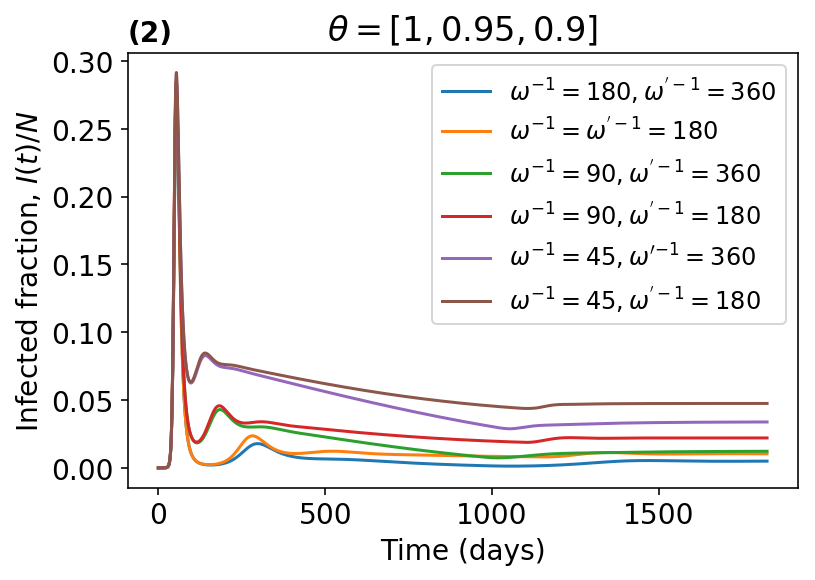

In [26]:
plt.plot(t,It_0/N,label=r"$\omega^{-1}=180,\omega^{'-1}=360$")
plt.plot(t,It_1/N,label=r"$\omega^{-1}=\omega^{'-1}=180$")
plt.plot(t,It_2/N,label=r"$\omega^{-1}=90,\omega^{'-1}=360$")
plt.plot(t,It_3/N,label=r"$\omega^{-1}=90,\omega^{'-1}=180$")
plt.plot(t,It_4/N,label=r"$\omega^{-1}=45,\omega'^{-1}=360$")
plt.plot(t,It_5/N,label=r"$\omega^{-1}=45,\omega^{'-1}=180$")
plt.legend(fontsize=12)
plt.title('(2)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[1,0.95,0.9]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [27]:
print(check_I(I_0,It_0,sigma,theta_0,1/180,1/360,var,var1,gamma,Rc,N))
print()
print(check_I(I_1,It_1,sigma,theta_0,1/180,1/180,var,var1,gamma,Rc,N))
print()
print(check_I(I_2,It_2,sigma,theta_0,1/90,1/360,var,var1,gamma,Rc,N))
print()
print(check_I(I_3,It_3,sigma,theta_0,1/90,1/180,var,var1,gamma,Rc,N))
print()
print(check_I(I_4,It_4,sigma,theta_0,1/45,1/360,var,var1,gamma,Rc,N))
print()
print(check_I(I_5,It_5,sigma,theta_0,1/45,1/180,var,var1,gamma,Rc,N))
print()

Re_0=get_Re(Rc,I_0,V_0,T_0,delta_m,var,var1)
Re_1=get_Re(Rc,I_1,V_1,T_1,delta_m,var,var1)
Re_2=get_Re(Rc,I_2,V_2,T_2,delta_m,var,var1)
Re_3=get_Re(Rc,I_3,V_3,T_3,delta_m,var,var1)
Re_4=get_Re(Rc,I_4,V_4,T_4,delta_m,var,var1)
Re_5=get_Re(Rc,I_5,V_5,T_5,delta_m,var,var1)

print(get_I_cum(sigma,t,Re_0,It_0)/(N))
print(get_I_cum(sigma,t,Re_1,It_1)/(N))
print(get_I_cum(sigma,t,Re_2,It_2)/(N))
print(get_I_cum(sigma,t,Re_3,It_3)/(N))
print(get_I_cum(sigma,t,Re_4,It_4)/(N))
print(get_I_cum(sigma,t,Re_5,It_5)/(N))

Experimental result: 0.0049408973780934095
Per year: 0.2576325061434421
0.0051704486890467

Experimental result: 0.01035249356023466
Per year: 0.5398085927836644
0.010476246780117344

Experimental result: 0.012206235579957767
Per year: 0.6364679980977979
0.0126031177899789

Experimental result: 0.02204133183452551
Per year: 1.1492980170859728
0.022120665917262687

Experimental result: 0.03381816633075806
Per year: 1.7633758158180988
0.03430908316537892

Experimental result: 0.04747916131938863
Per year: 2.47569912593955
0.047639580659694175

2.151893350618132
3.4758290739874105
5.00540776534849
7.105431072103568
11.99775816120956
14.634231476008928


# Change sigma

In [28]:
sigma_1=1/14
sigma_2=1/3.5

sol_1=odeint(model, y0, t, args=(Rc*sigma_1, sigma_1, omega, omega1, gamma, var, var1, delta_m, phi_m, theta, N,0.001))
sol_2=odeint(model, y0, t, args=(Rc*sigma_2, sigma_2, omega, omega1, gamma, var, var1, delta_m, phi_m, theta, N,0.001))

V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)
V_2,I_2,R_2,T_2,M_2,Vt_2,It_2,Rt_2,Tt_2,Mt_2,stage0_2,stage1_2,stage2_2,stage3_2=get_compartment(sol_2)


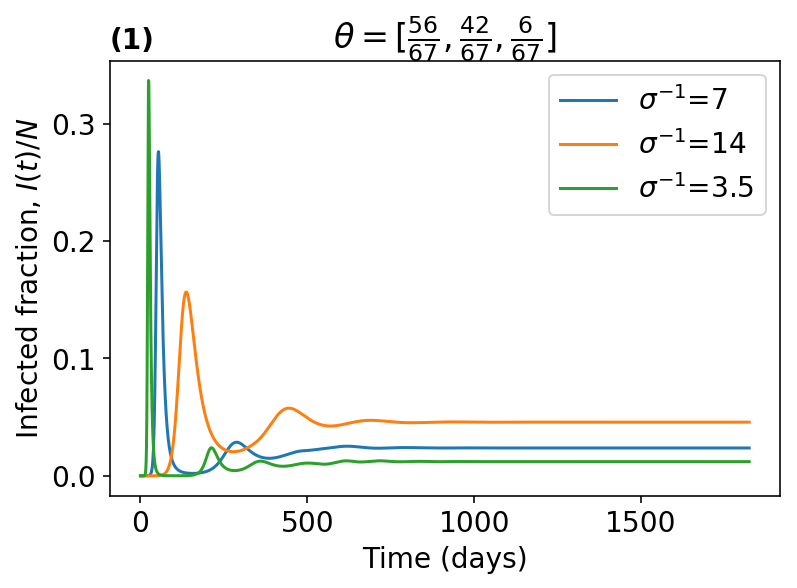

In [29]:
plt.plot(t,It/N,label=r"$\sigma^{-1}$=7")
plt.plot(t,It_1/N,label=r"$\sigma^{-1}$=14")
plt.plot(t,It_2/N,label=r"$\sigma^{-1}$=3.5")
plt.legend()
plt.title('(1)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[\frac{56}{67},\frac{42}{67},\frac{6}{67}]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [30]:
print(check_I(I_1,It_1,sigma_1,theta,omega,omega1,var,var1,gamma,Rc,N))
print()
print(check_I(I_2,It_2,sigma_2,theta,omega,omega1,var,var1,gamma,Rc,N))
print()
Re_1=get_Re(Rc,I_1,V_1,T_1,delta_m,var,var1)
Re_2=get_Re(Rc,I_2,V_2,T_2,delta_m,var,var1)
print(get_I_cum(sigma_1,t,Re_1,It_1)/(N))
print(get_I_cum(sigma_2,t,Re_2,It_2)/(N))

Experimental result: 0.045720591529715096
Per year: 1.1920011363104293
0.045760295764857406

Experimental result: 0.012090072838679376
Per year: 1.260821881747992
0.012145036419339703

5.946672929615972
6.481866717009004


In [31]:
sigma_1=1/14
sigma_2=1/3.5
sol_0=odeint(model, y0, t, args=(Rc*sigma, sigma, omega, omega1, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))
sol_1=odeint(model, y0, t, args=(Rc*sigma_1, sigma_1, omega, omega1, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))
sol_2=odeint(model, y0, t, args=(Rc*sigma_2, sigma_2, omega, omega1, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))
V_0,I_0,R_0,T_0,M_0,Vt_0,It_0,Rt_0,Tt_0,Mt_0,stage0_0,stage1_0,stage2_0,stage3_0=get_compartment(sol_0)
V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)
V_2,I_2,R_2,T_2,M_2,Vt_2,It_2,Rt_2,Tt_2,Mt_2,stage0_2,stage1_2,stage2_2,stage3_2=get_compartment(sol_2)


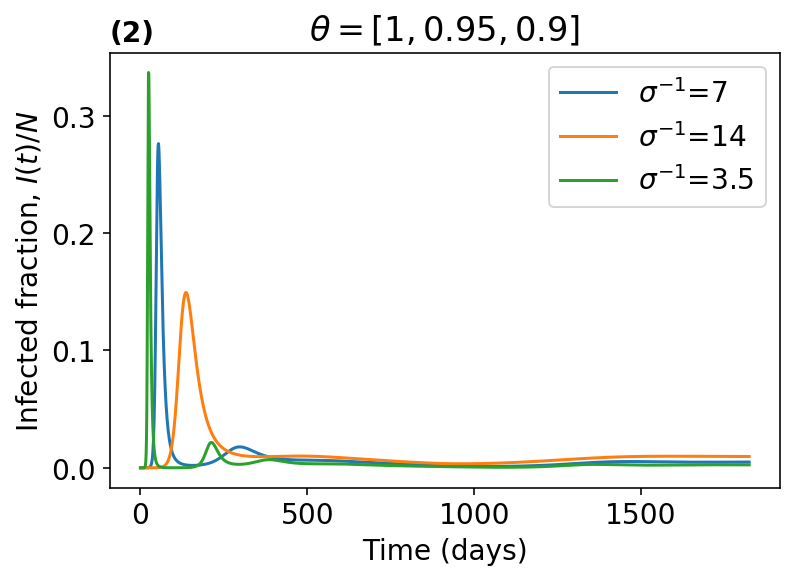

In [32]:
plt.plot(t,It_0/N,label=r"$\sigma^{-1}$=7")
plt.plot(t,It_1/N,label=r"$\sigma^{-1}$=14")
plt.plot(t,It_2/N,label=r"$\sigma^{-1}$=3.5")
plt.legend()
plt.title('(2)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[1, 0.95, 0.9]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [33]:
print(check_I(I_0,It_0,sigma,theta_0,omega,omega1,var,var1,gamma,Rc,N))
print()
print(check_I(I_1,It_1,sigma_1,theta_0,omega,omega1,var,var1,gamma,Rc,N))
print()
print(check_I(I_2,It_2,sigma_2,theta_0,omega,omega1,var,var1,gamma,Rc,N))
print()
Re_0=get_Re(Rc,I_0,V_0,T_0,delta_m,var,var1)
print(get_I_cum(sigma,t,Re_0,It_0)/(N))
Re_1=get_Re(Rc,I_1,V_1,T_1,delta_m,var,var1)
Re_2=get_Re(Rc,I_2,V_2,T_2,delta_m,var,var1)
print(get_I_cum(sigma_1,t,Re_1,It_1)/(N))
print(get_I_cum(sigma_2,t,Re_2,It_2)/(N))

Experimental result: 0.0049408973780934095
Per year: 0.2576325061434421
0.0051704486890467

Experimental result: 0.009643656098234206
Per year: 0.2514238911325346
0.009921828049117117

Experimental result: 0.002545839103769971
Per year: 0.26549464939315415
0.0026729195518849862

2.151893350618132
1.6787558606875268
2.3650036657294287


# Change efficiency

In [34]:
print(get_I_cum(sigma,t,Re_0,It_0)/(5*N))
print(get_I_cum(sigma_1,t,Re_1,It_1)/(5*N))
print(get_I_cum(sigma_2,t,Re_2,It_2)/(5*N))

0.4303786701236264
0.3357511721375053
0.47300073314588575


In [35]:
#var_1=[0,0.65,0.75,0.85]
#var_2=[0,0.55,0.85,0.85]
#var_3=[0,0.55,0.75,0.99]
var_1=[0,0.3,0.4,0.7]
var_2=[0,0.3,0.4,1]
var_3=[0,1,1,1]
sol_1=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma, var_1, var1, delta_m, phi_m, theta, N,0.001))
sol_2=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma, var_2, var1, delta_m, phi_m, theta, N,0.001))
sol_3=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma, var_3, var1, delta_m, phi_m, theta, N,0.001))

V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)
V_2,I_2,R_2,T_2,M_2,Vt_2,It_2,Rt_2,Tt_2,Mt_2,stage0_2,stage1_2,stage2_2,stage3_2=get_compartment(sol_2)
V_3,I_3,R_3,T_3,M_3,Vt_3,It_3,Rt_3,Tt_3,Mt_3,stage0_3,stage1_3,stage2_3,stage3_3=get_compartment(sol_3)
#V_4,I_4,R_4,T_4,M_4,Vt_4,It_4,Rt_4,Tt_4,Mt_4,stage0_4,stage1_4,stage2_4,stage3_4=get_compartment(sol_4)

In [36]:
Re_1=get_Re(Rc,I_1,V_1,T_1,delta_m,var_1,var1)
Re_2=get_Re(Rc,I_2,V_2,T_2,delta_m,var_2,var1)
Re_3=get_Re(Rc,I_3,V_3,T_3,delta_m,var_3,var1)
#Re_4=get_Re(Rc,I_4,V_4,T_4,delta_m,var_4,var1)

print(get_I_cum(sigma,t,Re_1,It_1)/(N))
print(get_I_cum(sigma,t,Re_2,It_2)/(N))
print(get_I_cum(sigma,t,Re_3,It_3)/(N))
#print(get_I_cum(sigma,t,Re_4,It_4)/(N))

6.816539916816561
6.391719960947852
4.81189779478827


In [37]:
check_I(I_1,It_1,sigma,theta,omega,omega1,var_1,var1,gamma,Rc,N)

Experimental result: 0.024225581144016364
Per year: 1.263191016795139


0.02421279057200811

In [38]:
check_I(I_2,It_2,sigma,theta,omega,omega1,var_2,var1,gamma,Rc,N)

Experimental result: 0.0227217600381691
Per year: 1.1847774877045316


0.02276088001908448

In [39]:
check_I(I_3,It_3,sigma,theta,omega,omega1,var_3,var1,gamma,Rc,N)

Experimental result: 0.022534832757338967
Per year: 1.1750305652041033


0.022767416378669414

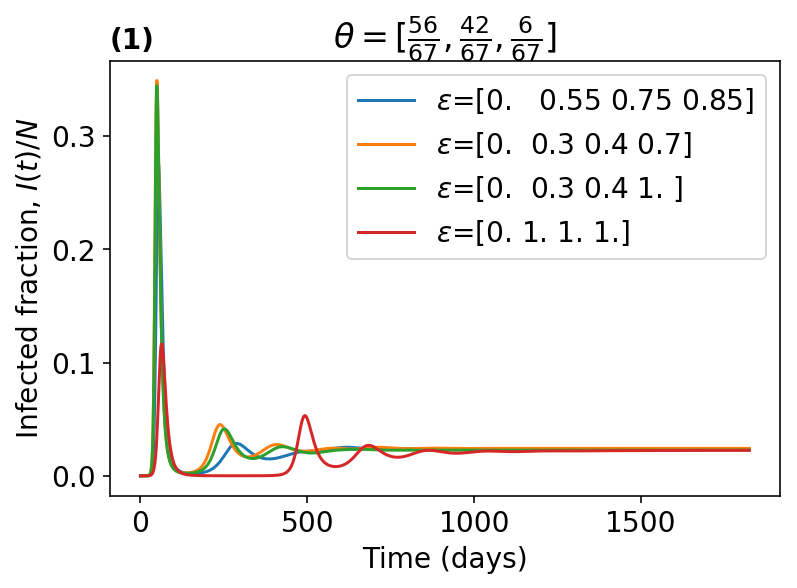

In [45]:
plt.plot(t,It/N,label=r"$\epsilon$="+str(np.round(var,2)))
plt.plot(t,It_1/N,label=r"$\epsilon$="+str(np.round(var_1,2)))
plt.plot(t,It_2/N,label=r"$\epsilon$="+str(np.round(var_2,2)))
plt.plot(t,It_3/N,label=r"$\epsilon$="+str(np.array(var_3).astype(float)))
#plt.plot(t,It_4/N,label=r"$\epsilon$="+str(np.round(var_4,2)))
plt.legend()
plt.title('(1)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[\frac{56}{67},\frac{42}{67},\frac{6}{67}]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [46]:
#var_1=[0,0.3,0.4,0.7]
#var_2=[0,0.3,0.5,0.7]
#var_3=[0,1,1,1]
sol_1=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma, var_1, var1, delta_m, phi_m, theta_0, N,0.001))
sol_2=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma, var_2, var1, delta_m, phi_m, theta_0, N,0.001))
sol_3=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma, var_3, var1, delta_m, phi_m, theta_0, N,0.001))

V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)
V_2,I_2,R_2,T_2,M_2,Vt_2,It_2,Rt_2,Tt_2,Mt_2,stage0_2,stage1_2,stage2_2,stage3_2=get_compartment(sol_2)
V_3,I_3,R_3,T_3,M_3,Vt_3,It_3,Rt_3,Tt_3,Mt_3,stage0_3,stage1_3,stage2_3,stage3_3=get_compartment(sol_3)


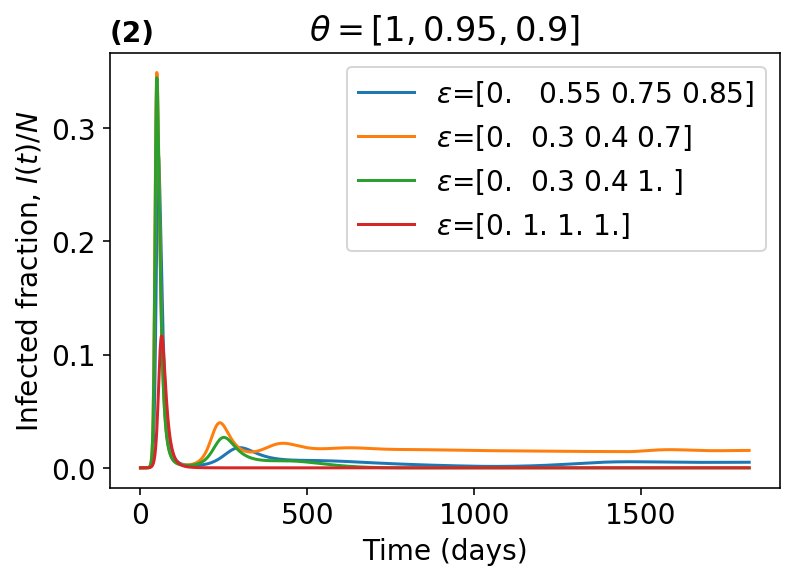

In [47]:
plt.plot(t,It_0/N,label=r"$\epsilon$="+str(np.round(var,2)))
plt.plot(t,It_1/N,label=r"$\epsilon$="+str(np.round(var_1,2)))
plt.plot(t,It_2/N,label=r"$\epsilon$="+str(np.round(var_2,2)))
plt.plot(t,It_3/N,label=r"$\epsilon$="+str(np.array(var_3).astype(float)))
#plt.plot(t,It_4/N,label=r"$\epsilon$="+str(np.round(var_4,2)))
plt.legend()
plt.title('(2)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[1,0.95,0.9]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [43]:
print(check_I(I_1,It_1,sigma,theta_0,omega,omega1,var_1,var1,gamma,Rc,N))
print()
print(check_I(I_2,It_2,sigma,theta_0,omega,omega1,var_2,var1,gamma,Rc,N))
print()
print(check_I(I_3,It_3,sigma,theta_0,omega,omega1,var_3,var1,gamma,Rc,N))
print()

Re_1=get_Re(Rc,I_1,V_1,T_1,delta_m,var_1,var1)
Re_2=get_Re(Rc,I_2,V_2,T_2,delta_m,var_2,var1)
Re_3=get_Re(Rc,I_3,V_3,T_3,delta_m,var_3,var1)
print(get_I_cum(sigma,t,Re_1,It_1)/(N))
print(get_I_cum(sigma,t,Re_2,It_2)/(N))
print(get_I_cum(sigma,t,Re_3,It_3)/(N))

Experimental result: 0.015394773946595575
Per year: 0.8027274986439121
0.015297386973297807

Experimental result: 7.111200049510088e-25
Per year: 3.707982882958831e-23
0.0005

Experimental result: 1.851896893775435e-32
Per year: 9.65631951754334e-31
0.0005

4.998511952173004
1.609793658665705
0.5042126013235888


# Change efficacy against infection following compartment T_i

In [44]:
var1_1=[0.1,0.3,0.4,0.5]

sol_1=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma, var, var1_1, delta_m, phi_m, theta, N,0.001))

V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)

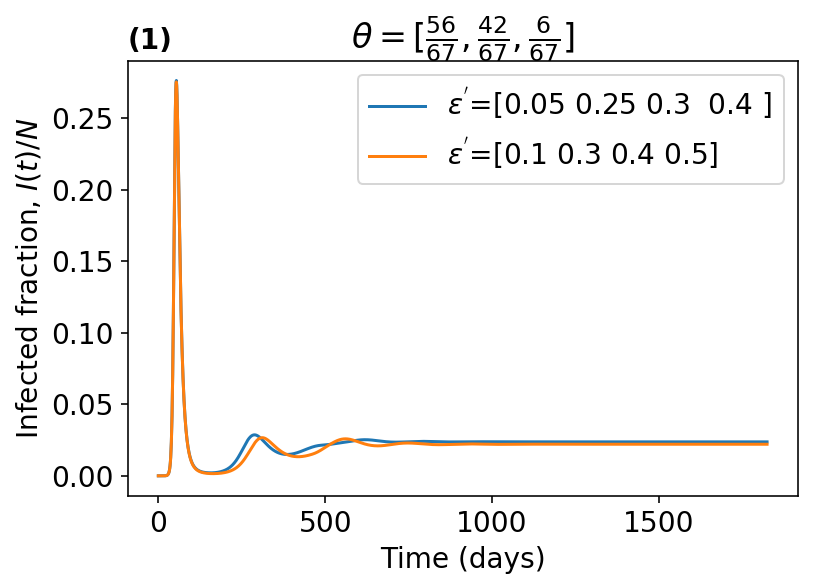

In [45]:
plt.plot(t,It/N,label=r"$\epsilon^{'}$="+str(np.round(var1,2)))
plt.plot(t,It_1/N,label=r"$\epsilon^{'}$="+str(np.round(var1_1,2)))

plt.legend(loc="upper right")
plt.title('(1)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[\frac{56}{67},\frac{42}{67},\frac{6}{67}]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [46]:
print(check_I(I_1,It_1,sigma,theta,omega,omega1,var,var1_1,gamma,Rc,N))
print()

Re_1=get_Re(Rc,I_1,V_1,T_1,delta_m,var,var1_1)
print(get_I_cum(sigma,t,Re_1,It_1)/(N))

Experimental result: 0.022067399219445984
Per year: 1.1506572450139692
0.022133699609722925

5.8796072046453425


In [47]:
var1_1=[0.1,0.3,0.4,0.5]

sol_1=odeint(model, y0,t, args=(beta, sigma, omega, omega1, gamma, var, var1_1, delta_m, phi_m, theta_0, N,0.001))

V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)

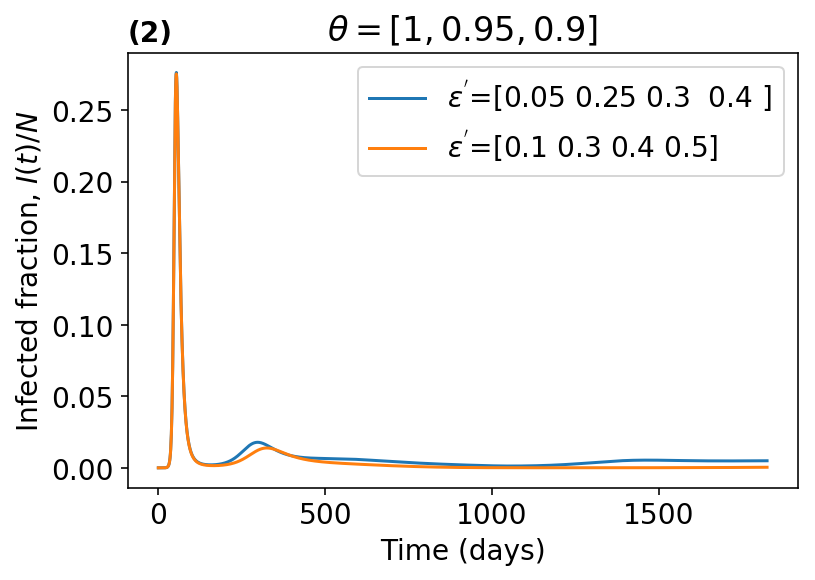

In [48]:
plt.plot(t,It_0/N,label=r"$\epsilon^{'}$="+str(np.round(var1,2)))
plt.plot(t,It_1/N,label=r"$\epsilon^{'}$="+str(np.round(var1_1,2)))

plt.legend(loc="upper right")
plt.title('(2)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[1,0.95,0.9]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [49]:
print(check_I(I_1,It_1,sigma,theta_0,omega,omega1,var,var1_1,gamma,Rc,N))
print()

Re_1=get_Re(Rc,I_1,V_1,T_1,delta_m,var,var1_1)
print(get_I_cum(sigma,t,Re_1,It_1)/(N))

Experimental result: 0.00040124907991509066
Per year: 0.020922273452715443
0.0018000000000000006

1.4133931947019045


# Change gamma

In [50]:
gamma_1=1/180
gamma_2=1/45

sol_1=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma_1, var, var1, delta_m, phi_m, theta, N,0.001))
sol_2=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma_2, var, var1, delta_m, phi_m, theta, N,0.001))

V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)
V_2,I_2,R_2,T_2,M_2,Vt_2,It_2,Rt_2,Tt_2,Mt_2,stage0_2,stage1_2,stage2_2,stage3_2=get_compartment(sol_2)


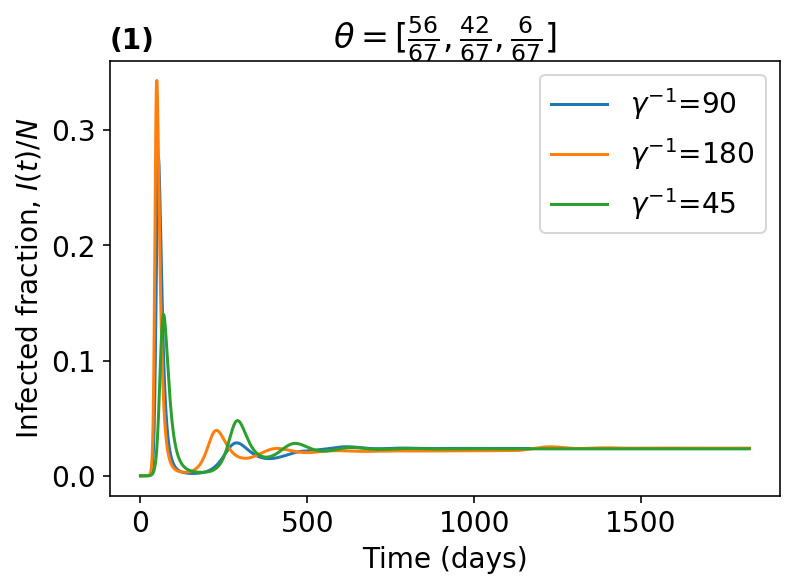

In [51]:
plt.plot(t,It/N,label=r"$\gamma^{-1}$=90")
plt.plot(t,It_1/N,label=r"$\gamma^{-1}$=180")
plt.plot(t,It_2/N,label=r"$\gamma^{-1}$=45")
#plt.plot(t,It_3/N,label=r"$\epsilon$="+str(np.round(var_3,2)))
plt.legend()
plt.title('(1)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[\frac{56}{67},\frac{42}{67},\frac{6}{67}]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [52]:
print(np.max(It/N))
print(np.max(It_1/N))
print(np.max(It_2/N))

0.2762436668819522
0.3432340240120498
0.14019198643476033


In [53]:
check_I(I_1,It_1,sigma,theta,omega,omega1,var,var1,gamma_1,Rc,N)

Experimental result: 0.024025686842465907
Per year: 1.2527679567857224


0.02401284342123288

In [54]:
check_I(I_2,It_2,sigma,theta,omega,omega1,var,var1,gamma_2,Rc,N)

Experimental result: 0.023439280634596524
Per year: 1.2221910616611045


0.02351964031729819

In [55]:
Re_1=get_Re(Rc,I_1,V_1,T_1,delta_m,var,var1)
Re_2=get_Re(Rc,I_2,V_2,T_2,delta_m,var,var1)


print(get_I_cum(sigma,t,Re_1,It_1)/(N))
print(get_I_cum(sigma,t,Re_2,It_2)/(N))

6.457862928258121
6.256489911272692


In [56]:
gamma_1=1/180
gamma_2=1/45

sol_1=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma_1, var, var1, delta_m, phi_m, theta_0, N,0.001))
sol_2=odeint(model, y0, t, args=(beta, sigma, omega, omega1, gamma_2, var, var1, delta_m, phi_m, theta_0, N,0.001))

V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)
V_2,I_2,R_2,T_2,M_2,Vt_2,It_2,Rt_2,Tt_2,Mt_2,stage0_2,stage1_2,stage2_2,stage3_2=get_compartment(sol_2)


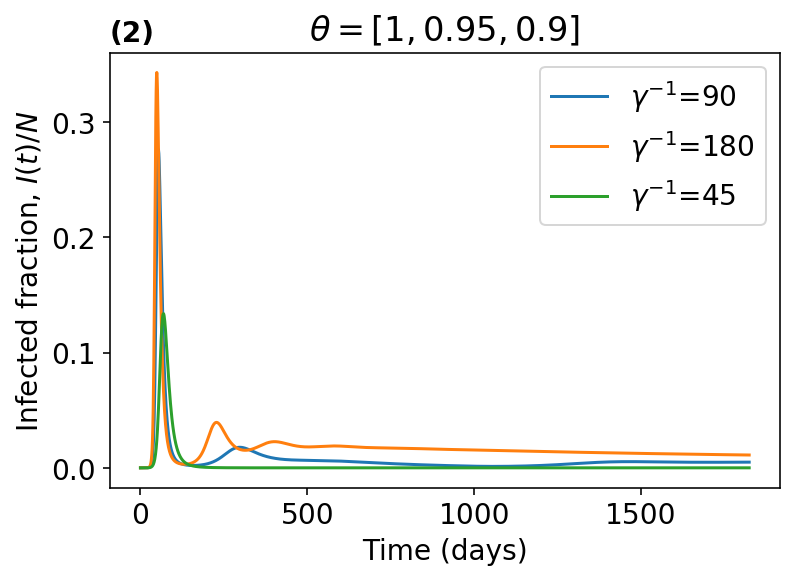

In [57]:
plt.plot(t,It_0/N,label=r"$\gamma^{-1}$=90")
plt.plot(t,It_1/N,label=r"$\gamma^{-1}$=180")
plt.plot(t,It_2/N,label=r"$\gamma^{-1}$=45")
plt.legend()
plt.title('(2)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[1,0.95,0.9]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [58]:
print(np.max(It_0/N))
print(np.max(It_1/N))
print(np.max(It_2/N))

0.2762436668819522
0.3432340240120498
0.1338555897831179


In [59]:
print(check_I(I_1,It_1,sigma,theta_0,omega,omega1,var,var1,gamma_1,Rc,N))
print()
print(check_I(I_2,It_2,sigma,theta_0,omega,omega1,var,var1,gamma_2,Rc,N))
print()

Re_1=get_Re(Rc,I_1,V_1,T_1,delta_m,var,var1)
Re_2=get_Re(Rc,I_2,V_2,T_2,delta_m,var,var1)
print(get_I_cum(sigma,t,Re_1,It_1)/(N))
print(get_I_cum(sigma,t,Re_2,It_2)/(N))

Experimental result: 0.011136097192581913
Per year: 0.5806679250417712
0.011568048596290972

Experimental result: 5.8005970418511955e-11
Per year: 3.024597028965266e-09
0.0005

4.854024652379377
0.6979698630494908


In [60]:
sol_1=odeint(model, y0, t, args=(6*sigma, sigma, omega, omega1, gamma, var, var1, delta_m, phi_m, theta, N,0.001))
sol_2=odeint(model, y0, t, args=(8*sigma, sigma, omega, omega1, gamma, var, var1, delta_m, phi_m, theta, N,0.001))

V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)
V_2,I_2,R_2,T_2,M_2,Vt_2,It_2,Rt_2,Tt_2,Mt_2,stage0_2,stage1_2,stage2_2,stage3_2=get_compartment(sol_2)

In [61]:
Re_1=get_Re(6,I_1,V_1,T_1,delta_m,var,var1)
Re_2=get_Re(8,I_2,V_2,T_2,delta_m,var,var1)
print(get_I_cum(sigma,t,Re_1,It_1)/(N))
print(get_I_cum(sigma,t,Re_2,It_2)/(N))

7.792197651124326
8.554507156604236


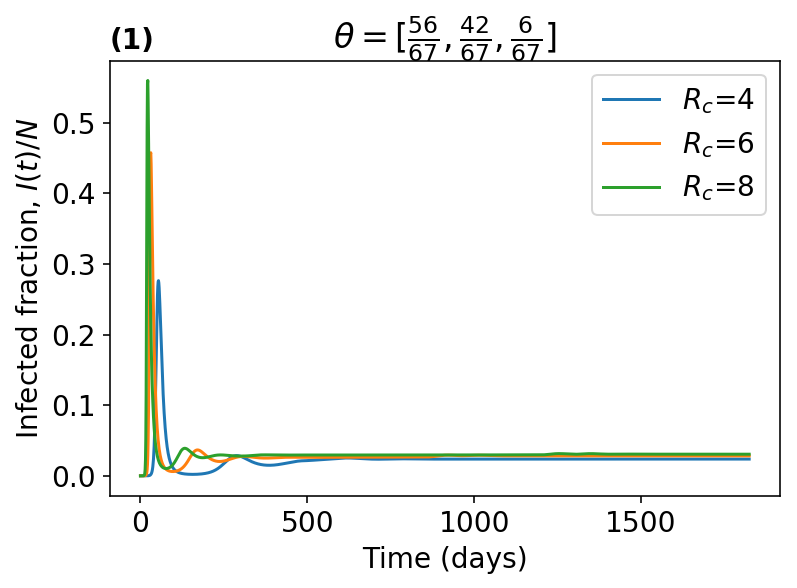

In [62]:
plt.plot(t,It/N,label=r"$R_{c}$=4")
plt.plot(t,It_1/N,label=r"$R_{c}$=6")
plt.plot(t,It_2/N,label=r"$R_{c}$=8")

plt.legend()
plt.title('(1)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[\frac{56}{67},\frac{42}{67},\frac{6}{67}]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [63]:
check_I(I_1,It_1,sigma,theta,omega,omega1,var,var1,gamma,6,N)

Experimental result: 0.028293603456954173
Per year: 1.4753093231126104


0.028346801728477

In [64]:
check_I(I_2,It_2,sigma,theta,omega,omega1,var,var1,gamma,8,N)

Experimental result: 0.03061368177455489
Per year: 1.596284835387505


0.030606840887277352

In [65]:
sol_1=odeint(model, y0, t, args=(6*sigma, sigma, omega, omega1, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))
sol_2=odeint(model, y0, t, args=(8*sigma, sigma, omega, omega1, gamma, var, var1, delta_m, phi_m, theta_0, N,0.001))

V_1,I_1,R_1,T_1,M_1,Vt_1,It_1,Rt_1,Tt_1,Mt_1,stage0_1,stage1_1,stage2_1,stage3_1=get_compartment(sol_1)
V_2,I_2,R_2,T_2,M_2,Vt_2,It_2,Rt_2,Tt_2,Mt_2,stage0_2,stage1_2,stage2_2,stage3_2=get_compartment(sol_2)

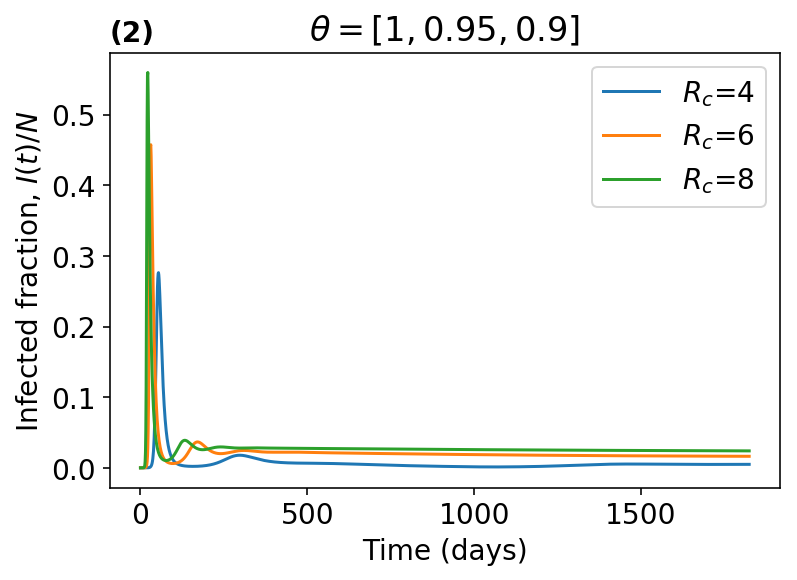

In [66]:
plt.plot(t,It_0/N,label=r"$R_{c}$=4")
plt.plot(t,It_1/N,label=r"$R_{c}$=6")
plt.plot(t,It_2/N,label=r"$R_{c}$=8")

plt.legend()
plt.title('(2)', fontsize=14, fontweight='bold',loc='left')
plt.title(r"$\theta=[1,0.95,0.9]$")
plt.xlabel("Time (days)")
plt.ylabel(r"Infected fraction, $I(t)/N$")
plt.show()

In [67]:
print(check_I(I_1,It_1,sigma,theta_0,omega,omega1,var,var1,gamma,6,N))
print()
print(check_I(I_2,It_2,sigma,theta_0,omega,omega1,var,var1,gamma,8,N))
print()

Re_1=get_Re(6,I_1,V_1,T_1,delta_m,var,var1)
Re_2=get_Re(8,I_2,V_2,T_2,delta_m,var,var1)
print(get_I_cum(sigma,t,Re_1,It_1)/(N))
print(get_I_cum(sigma,t,Re_2,It_2)/(N))

Experimental result: 0.01632570691088668
Per year: 0.8512690032105197
0.017762853455443282

Experimental result: 0.023990806908146242
Per year: 1.2509492173533396
0.02389540345407305

5.862318425083258
7.628021048704818
